## Import required modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import plot_tree
import shap

## Load csv files into dataframes, explore links and join them

In [2]:
core_df = pd.read_csv('core_dataset.csv').dropna(axis=0, how='all')

hrd13 = pd.read_csv('HRDataset_v13.csv').dropna(axis=0, how='all')

hrd9 = pd.read_csv('HRDataset_v9.csv').dropna(axis=0, how='all')

prodstaff_df = pd.read_csv('production_staff.csv').dropna(axis=0, how='all')

recruitcosts_df = pd.read_csv('recruiting_costs.csv').dropna(axis=0, how='all')

salary_df = pd.read_csv('salary_grid.csv', skiprows=1).dropna(axis=0, how='all').dropna(axis=1, how='any')
salary_df.columns = ['Position', 'SalaryMin', 'SalaryMid', 'SalaryMax', 'HourlyMin', 'HourlyMid', 'HourlyMax']

In [3]:
hrd9.head()

,Employee Name,Employee Number,MarriedID,MaritalStatusID,GenderID,EmpStatus_ID,DeptID,Perf_ScoreID,Age,Pay Rate,...,Date of Hire,Days Employed,Date of Termination,Reason For Term,Employment Status,Department,Position,Manager Name,Employee Source,Performance Score
0,"Brown, Mia",1103024456,1,1,0,1,1,3,30,28.50,...,10/27/2008,3317,NaN,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Diversity Job Fair,Fully Meets
1,"LaRotonda, William",1106026572,0,2,1,1,1,3,34,23.00,...,1/6/2014,1420,NaN,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Website Banner Ads,Fully Meets
2,"Steans, Tyrone",1302053333,0,0,1,1,1,3,31,29.00,...,9/29/2014,1154,NaN,N/A - still employed,Active,Admin Offices,Accountant I,Brandon R. LeBlanc,Internet Search,Fully Meets
3,"Howard, Estelle",1211050782,1,1,0,1,1,9,32,21.50,...,2/16/2015,58,4/15/2015,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Pay Per Click - Google,N/A- too early to review
4,"Singh, Nan",1307059817,0,0,0,1,1,9,30,16.56,...,5/1/2015,940,NaN,N/A - still employed,Active,Admin Offices,Administrative Assistant,Brandon R. LeBlanc,Website Banner Ads,N/A- too early to review


In [4]:
hrd9.columns

Index(['Employee Name', 'Employee Number', 'MarriedID', 'MaritalStatusID',
       'GenderID', 'EmpStatus_ID', 'DeptID', 'Perf_ScoreID', 'Age', 'Pay Rate',
       'State', 'Zip', 'DOB', 'Sex', 'MaritalDesc', 'CitizenDesc',
       'Hispanic/Latino', 'RaceDesc', 'Date of Hire', 'Days Employed',
       'Date of Termination', 'Reason For Term', 'Employment Status',
       'Department', 'Position', 'Manager Name', 'Employee Source',
       'Performance Score'],
      dtype='object')

In [5]:
# Check if there are columns in core_df that are absent in hrd9
print(set(core_df.columns)-set(hrd9.columns))

set()


In [6]:
# Check if there are columns in prodstaff_df that are absent in hrd9, use those later
print(set(prodstaff_df.columns)-set(hrd9.columns))

{'Pay', '90-day Complaints', 'Race Desc', 'Abutments/Hour Wk 2', 'Daily Error Rate', 'Abutments/Hour Wk 1', 'TermDate', 'Reason for Term'}


In [7]:
# Merge '90-day Complaints', 'Daily Error Rate' with hrd9
hrd9 = pd.merge(hrd9, prodstaff_df[['Employee Name', '90-day Complaints', 'Daily Error Rate']], on='Employee Name', how='left')

In [8]:
# find positions missing from salary_df
missing_pos = set(hrd9['Position']) - set(salary_df['Position'])
missing_pos

{'Area Sales Manager',
 'BI Developer',
 'BI Director',
 'CIO',
 'Data Architect',
 'Director of Operations',
 'Director of Sales',
 'IT Director',
 'IT Manager - DB',
 'IT Manager - Infra',
 'IT Manager - Support',
 'IT Support',
 'President & CEO',
 'Production Manager',
 'Sales Manager',
 'Senior BI Developer',
 'Shared Services Manager',
 'Software Engineer',
 'Software Engineering Manager'}

In [9]:
# get the hourly min, mid and max of the missing positions from hrd9
salary_missing = hrd9[['Position', 'Pay Rate']].groupby(['Position']).agg(['min', 'median', 'max']).reset_index()
salary_missing.columns = ['Position', 'HourlyMin', 'HourlyMid', 'HourlyMax']
salary_missing = salary_missing[salary_missing['Position'].isin(list(missing_pos))]
# add missing positions to salary_df and then salary_df with hrd9
salary_df = pd.concat([salary_df, salary_missing], axis=0)
hrd9 = pd.merge(hrd9, salary_df[['Position', 'HourlyMin', 'HourlyMid', 'HourlyMax']], on='Position', how='left')

## Missing value imputation

In [10]:
# list missing columns
hrd9.columns[hrd9.isna().any()].tolist()

['Date of Termination', '90-day Complaints', 'Daily Error Rate']

In [11]:
# convert dates to datetime format
hrd9['Date of Hire'] = pd.to_datetime(hrd9['Date of Hire'])
hrd9['Date of Termination'] = pd.to_datetime(hrd9['Date of Termination'])
#hrd9['Date of Termination'] = hrd9['Date of Hire'] + pd.to_timedelta(hrd9['Days Employed'],'d')

In [12]:
hrd9['90-day Complaints'].value_counts(dropna=False)

0.0    163
NaN    103
1.0     28
2.0     11
3.0      4
4.0      1
Name: 90-day Complaints, dtype: int64

In [13]:
hrd9['Daily Error Rate'].value_counts(dropna=False)

NaN    103
0.0     95
1.0     65
2.0     24
3.0     17
4.0      6
Name: Daily Error Rate, dtype: int64

In [14]:
# replace NaN with 0: the majority case
hrd9['90-day Complaints'].fillna(0, inplace=True)
hrd9['Daily Error Rate'].fillna(0, inplace=True)

## Feature Selection and Feature Engineering

In [15]:
# Check one to one association between the following pairs:
# MaritalStatusID - MaritalDesc'
# EmpStatus_ID - Employment Status
# DeptID - Department
# GenderID - Sex
# Perf_ScoreID - Performance Score

def is_one_to_one(df, col1, col2):
    lhs = (df.groupby(col1).agg({col2: lambda x: x.nunique()})>1).any().iloc[0]
    rhs = (df.groupby(col2).agg({col1: lambda x: x.nunique()})>1).any().iloc[0]
    if lhs==False and rhs==False:
        return True
    return False

print('Checking one-to-one relationships between columns:')
print(is_one_to_one(hrd9, 'MaritalStatusID', 'MaritalDesc'))
print(is_one_to_one(hrd9, 'EmpStatus_ID', 'Employment Status'))
print(is_one_to_one(hrd9, 'DeptID', 'Department'))
print(is_one_to_one(hrd9, 'GenderID', 'Sex'))
print(is_one_to_one(hrd9, 'Perf_ScoreID', 'Performance Score'))

Checking one-to-one relationships between columns:
True
True
True
True
True


In [16]:
# is payrate greater than/ equal to mid for that position or not
hrd9['payRate>=mid'] = (hrd9['Pay Rate'] >= hrd9['HourlyMid']).astype(int)

In [17]:
# convert days to years
hrd9['Years Employed'] = hrd9['Days Employed'] / 365

#### Inspect dataframe and create a new, cleaned numeric version for modeling

In [18]:
cols = ['MarriedID', 'MaritalStatusID', 'GenderID', 'EmpStatus_ID', 'DeptID', 'Perf_ScoreID', 'Age', 'Pay Rate', 
 'State', 'Zip', 'Sex', 'MaritalDesc', 'CitizenDesc', 'Hispanic/Latino', 'RaceDesc', 'Reason For Term', 
 'Employment Status', 'Department', 'Position', 'Manager Name', 'Employee Source', 'Performance Score', 
 '90-day Complaints', 'Daily Error Rate', 'HourlyMin', 'HourlyMid', 'HourlyMax', 'payRate>=mid', 'Years Employed']

for col in cols:
    if hrd9[col].dtype=='object':
        print(hrd9[col].value_counts())
    else:
        print(hrd9[col].describe())
    print()

count    310.000000
mean       0.396774
std        0.490019
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: MarriedID, dtype: float64

count    310.000000
mean       0.809677
std        0.944702
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: MaritalStatusID, dtype: float64

count    310.000000
mean       0.429032
std        0.495738
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: GenderID, dtype: float64

count    310.000000
mean       2.396774
std        1.795533
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max        5.000000
Name: EmpStatus_ID, dtype: float64

count    310.000000
mean       4.606452
std        1.082349
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        6.000000
Name: DeptID, dtype: float64

count    310.000000
mean      

In [19]:
# create a new version of dataframe by dropping non-useful or redundant columns
hrd9_v1 = hrd9.drop(columns=['DOB', 'DeptID', 'EmpStatus_ID', 'Employee Name', 'Employee Number', 'GenderID', \
                   'MaritalStatusID', 'MarriedID', 'Perf_ScoreID', 'State', 'Zip', 'Date of Termination',\
                   'Date of Hire', 'Days Employed', 'Hispanic/Latino', 'Manager Name'])

In [20]:
hrd9_v1['Sex'].replace({'Male':0, 'Female':1}, inplace=True)

In [21]:
# inspect categorical variables
total = 0
for col in hrd9_v1.columns:
    if hrd9_v1[col].dtype == 'object':
        print(col, hrd9_v1[col].unique())
        total += len(hrd9_v1[col].unique())
        print()
total

MaritalDesc ['Married' 'Divorced' 'Single' 'Separated' 'Widowed']

CitizenDesc ['US Citizen' 'Eligible NonCitizen' 'Non-Citizen']

RaceDesc ['Black or African American' 'White' 'Asian' 'Two or more races'
 'Hispanic' 'American Indian or Alaska Native']

Reason For Term ['N/A - still employed' 'career change' 'performance' 'no-call, no-show'
 'hours' 'medical issues' 'N/A - Has not started yet' 'Another position'
 'retiring' 'attendance' 'unhappy' 'return to school'
 'relocation out of area' 'military' 'more money'
 'maternity leave - did not return' 'gross misconduct']

Employment Status ['Active' 'Voluntarily Terminated' 'Terminated for Cause'
 'Leave of Absence' 'Future Start']

Department ['Admin Offices' 'Executive Office' 'IT/IS' 'Production       ' 'Sales'
 'Software Engineering']

Position ['Accountant I' 'Administrative Assistant' 'Shared Services Manager'
 'Sr. Accountant' 'President & CEO' 'CIO' 'Database Administrator'
 'IT Director' 'IT Manager - DB' 'IT Manager - Infra'
 '

100

In [22]:
# one-hot encode categorical variables
total = 0
for col in set(hrd9_v1.columns)-set(['Reason For Term', 'Employment Status', 'Performance Score']):
    if hrd9_v1[col].dtype == 'object':
        temp = pd.get_dummies(hrd9_v1[col])
        temp.columns = [col+'_'+str(x) for x in temp.columns]
        hrd9_v1 = pd.concat([hrd9_v1, temp], axis=1)
        hrd9_v1.drop(columns=[col], inplace=True)

In [23]:
# convert performance score to ordinal variable
hrd9_v1['Performance Score'].replace({'PIP':1, 'Needs Improvement':2, '90-day meets':3, 'N/A- too early to review':4, 'Fully Meets':4, 'Exceeds':5, 'Exceptional':6}, inplace=True)

In [24]:
# drop 'terminated for cause' and 'future start' and encode 'voluntarily left' as 1 and others cases as 0
hrd9_v1 = hrd9_v1[(hrd9_v1['Employment Status']!='Terminated for Cause') & (hrd9_v1['Employment Status']!='Future Start')].copy()
hrd9_v1['Employment Status'].replace({'Active':0, 'Leave of Absence':0, 'Voluntarily Terminated':1}, inplace=True)
hrd9_v1.drop(columns=['Reason For Term'], inplace=True)
len(hrd9_v1)

285

## Visualize correlations between new features and target variable: Employment Status

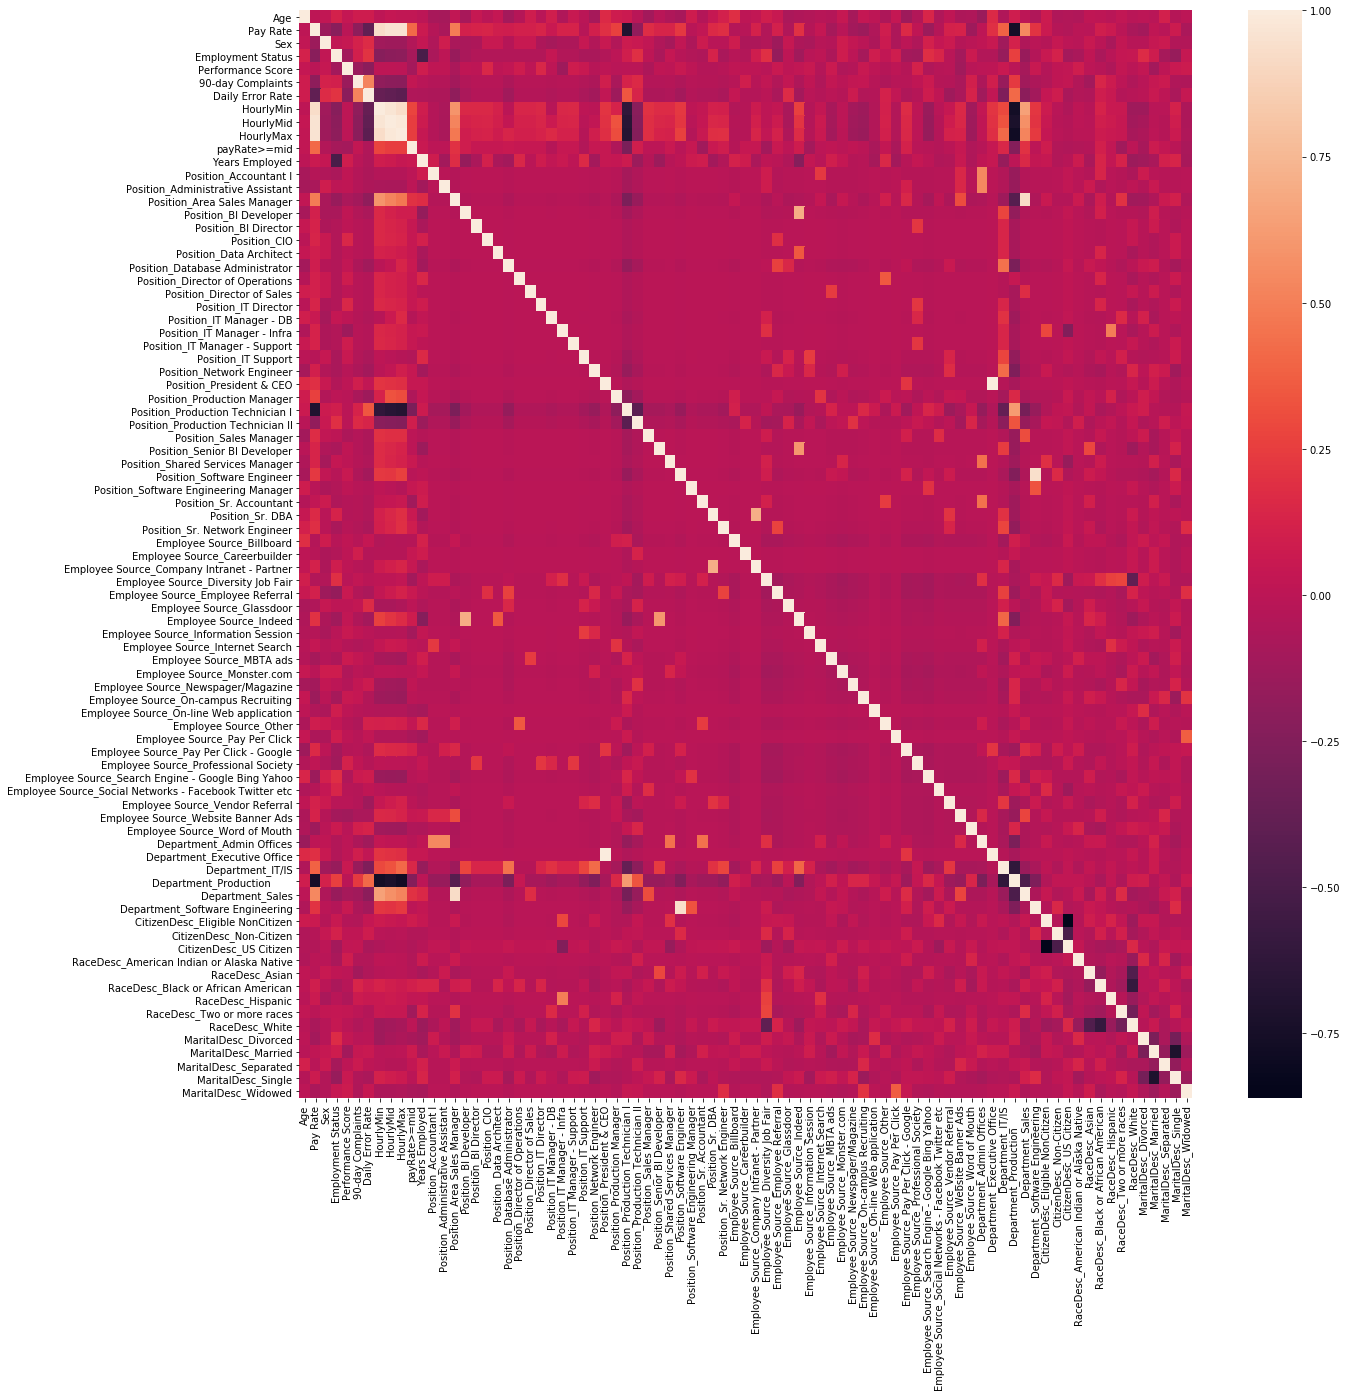

In [25]:
# plot heatmap of the pairwise correlations of all pairs of attributes
plt.figure(figsize=(20,20))
sns.heatmap(hrd9_v1.corr())
plt.show()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


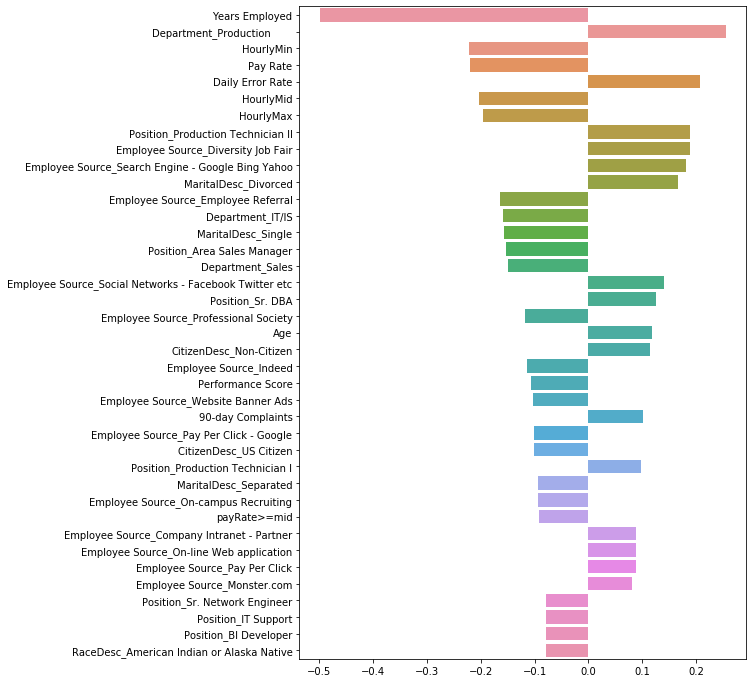

In [26]:
# plot heatmap of correlations of all attributes versus the employment status attribute (response or target variable)
plt.figure(figsize=(8,12))
corrs = hrd9_v1.corr()['Employment Status'].sort_values(key=abs, ascending=False).iloc[1:40]
sns.barplot(corrs.values, corrs.index, orient="h")
plt.show()

## Model building and evaluation

In [27]:
# Split data into training and testing set
x = hrd9_v1.drop(columns=['Employment Status'])
y = hrd9_v1['Employment Status']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.18, random_state=17, stratify=y)
ytrain.value_counts(), ytest.value_counts()

(0    161
 1     72
 Name: Employment Status, dtype: int64,
 0    36
 1    16
 Name: Employment Status, dtype: int64)

### Decision Tree

In [28]:
# overfit decision tree to get the maximum depth
for max_depth in np.arange(1,14,1):
    dt = DecisionTreeClassifier(max_depth=max_depth, max_features=None)
    dt.fit(xtrain, ytrain)
    print("Accuracy at max_depth={} is {}".format(max_depth, dt.score(xtrain, ytrain)))

Accuracy at max_depth=1 is 0.8283261802575107
Accuracy at max_depth=2 is 0.8669527896995708
Accuracy at max_depth=3 is 0.8841201716738197
Accuracy at max_depth=4 is 0.9098712446351931
Accuracy at max_depth=5 is 0.927038626609442
Accuracy at max_depth=6 is 0.944206008583691
Accuracy at max_depth=7 is 0.9570815450643777
Accuracy at max_depth=8 is 0.9699570815450643
Accuracy at max_depth=9 is 0.9785407725321889
Accuracy at max_depth=10 is 0.9828326180257511
Accuracy at max_depth=11 is 0.9871244635193133
Accuracy at max_depth=12 is 0.9914163090128756
Accuracy at max_depth=13 is 1.0


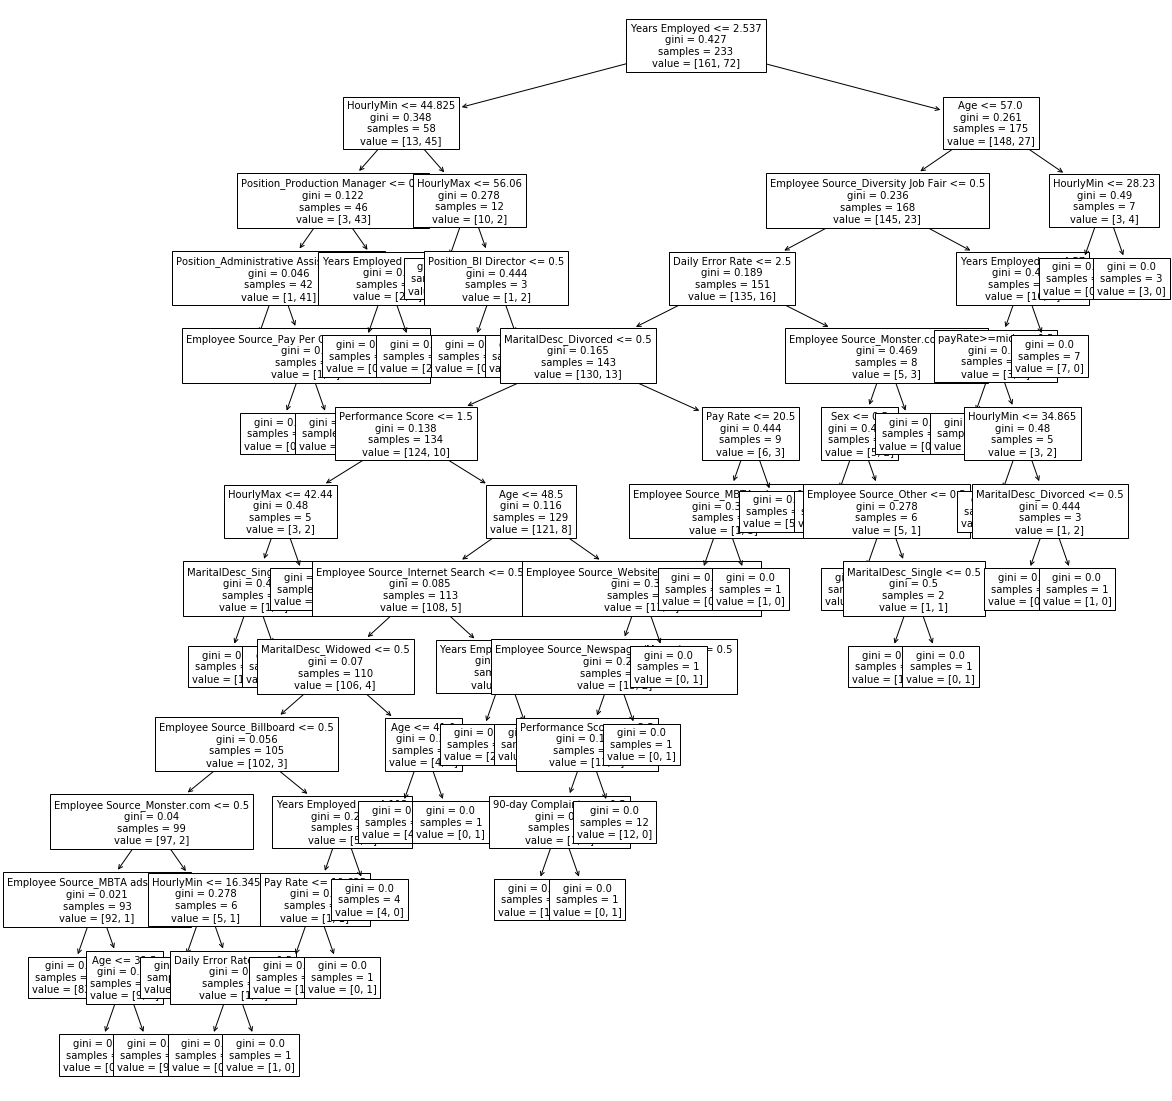

In [29]:
# Visualize the overfitted tree
plt.figure(figsize=(20,20))
plot_tree(dt, feature_names=xtrain.columns, fontsize=10)
plt.show()

In [113]:
dt.best_params_

{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 12}

In [30]:
# Run grid search on all parameters with 5-fold cross validation to get the best Decision Tree model/ estimator
parameters = {'max_depth':np.arange(1,15), 'min_samples_split':np.arange(2,15), 'min_samples_leaf':np.arange(1,15)}
dt = GridSearchCV(DecisionTreeClassifier(max_features=None), parameters, scoring='roc_auc')
dt.fit(xtrain, ytrain)
print('Training and testing accuracies:')
dt.best_estimator_.score(xtrain, ytrain), dt.best_estimator_.score(xtest, ytest)

Training and testing accuracies:


(0.871244635193133, 0.8846153846153846)

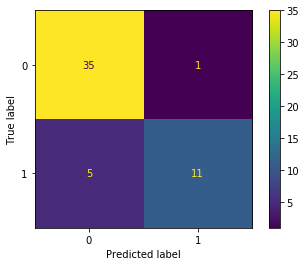

In [31]:
# Plot confusion matrix
plot_confusion_matrix(dt.best_estimator_, xtest, ytest)

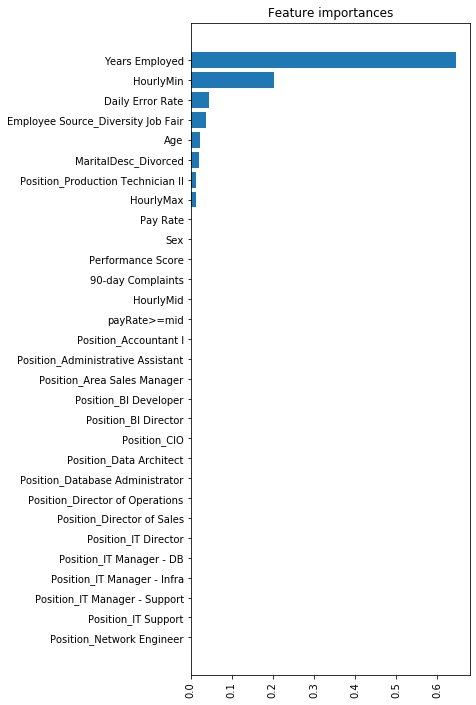

In [32]:
# Plot feature importances 
plt.figure(figsize=(5,12))
feat_importances = dt.best_estimator_.feature_importances_
srt = sorted(zip(xtrain.columns, feat_importances), key=lambda k: (-k[1]))
srt = list(map(list, zip(*srt)))
plt.title('Feature importances')
plt.barh(srt[0][:30], srt[1][:30])
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

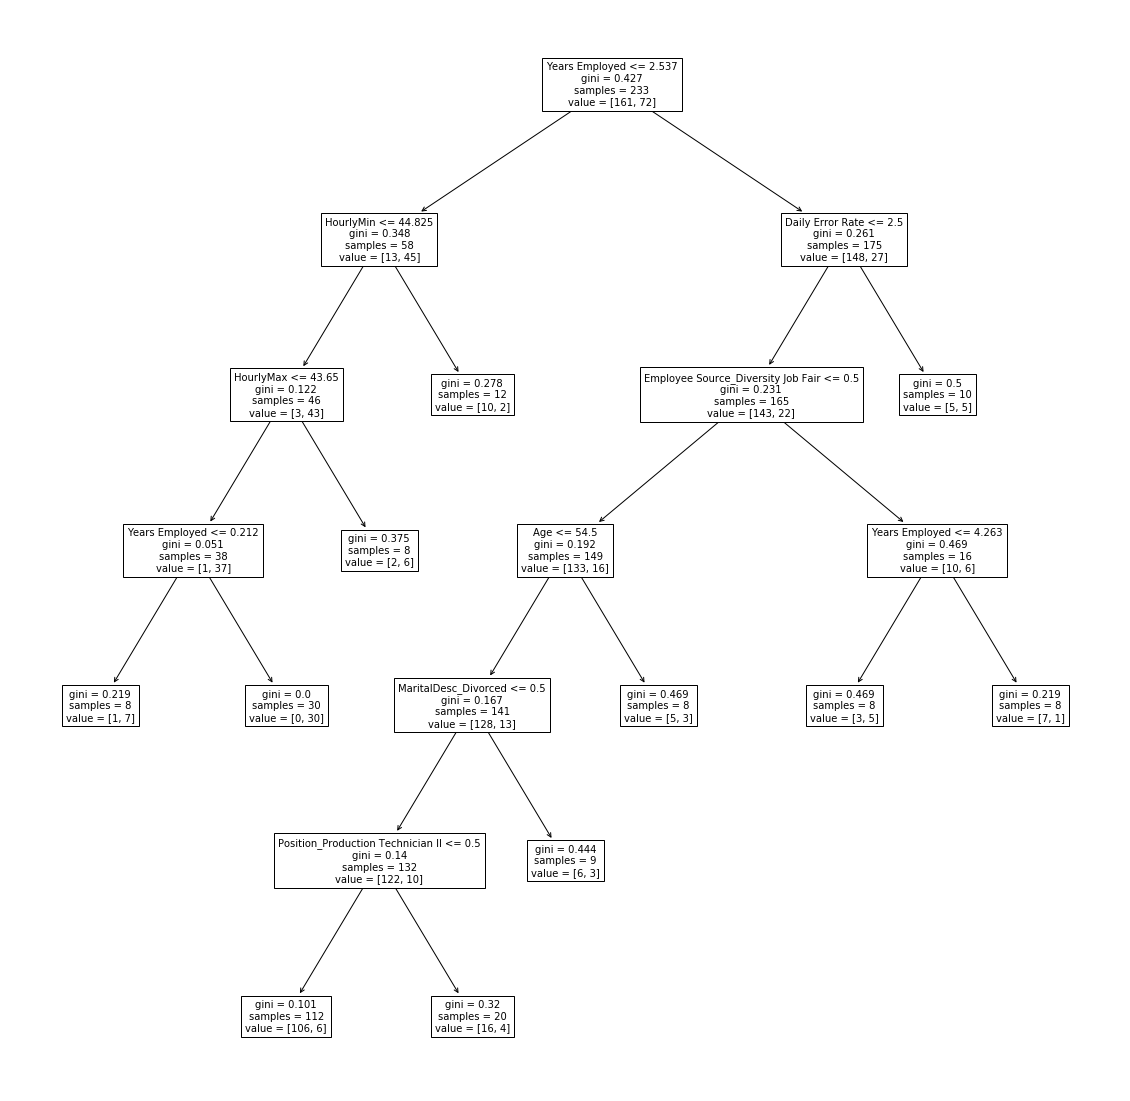

In [33]:
# Visualize best decision tree
plt.figure(figsize=(20,20))
plot_tree(dt.best_estimator_, feature_names=xtrain.columns, fontsize=10)
plt.show()

### Logistic Regression

In [34]:
# Run grid search on all parameters with 5-fold cross validation to get the best Logistic Regression model/ estimator from
parameters = {'C':[1e-3, 1e-2, 1e-1, 1, 10]}
lr = GridSearchCV(LogisticRegression(max_iter=2000), parameters, scoring='roc_auc')
lr.fit(xtrain, ytrain)
lr.best_estimator_.score(xtrain, ytrain), lr.best_estimator_.score(xtest, ytest)

(0.9055793991416309, 0.8653846153846154)

In [114]:
lr.best_params_

{'C': 0.1}

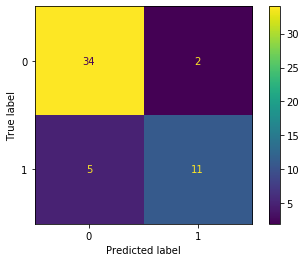

In [35]:
# Plot confusion matrix
plot_confusion_matrix(lr.best_estimator_, xtest, ytest)

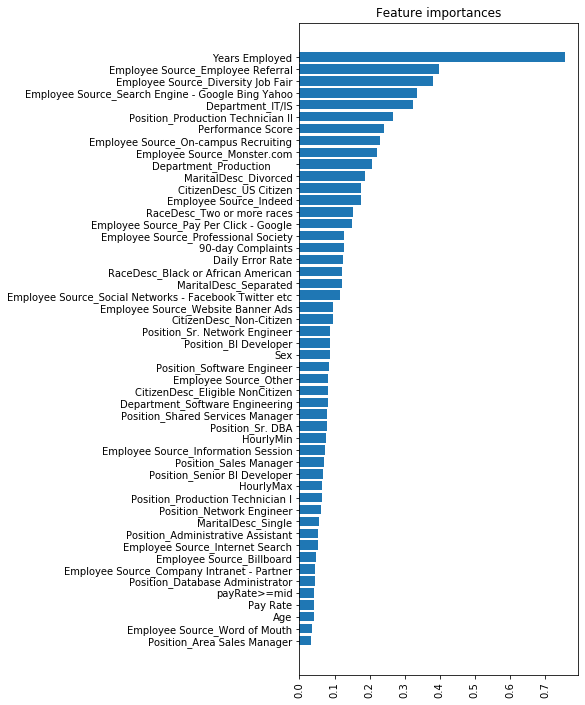

In [36]:
# Plot feature importances 
plt.figure(figsize=(5,12))
feat_importances = np.abs(lr.best_estimator_.coef_[0])
srt = sorted(zip(xtrain.columns, feat_importances), key=lambda k: (-k[1]))
srt = list(map(list, zip(*srt)))
plt.title('Feature importances')
plt.barh(srt[0][:50], srt[1][:50])
plt.xticks(rotation=90)
plt.gca().invert_yaxis()
plt.show()

## Visualizations to bring together the insights

In [108]:
hrd9_v2 = hrd9[(hrd9['Employment Status']!='Terminated for Cause') & (hrd9['Employment Status']!='Future Start')].copy()
hrd9_v2['Employment Status'].replace({'Active':'active', 'Leave of Absence':'active',\
                                      'Voluntarily Terminated':'terminated'}, inplace=True)
hrd9_v2['payRate>=mid'].replace({0:'no', 1:'yes'}, inplace=True)

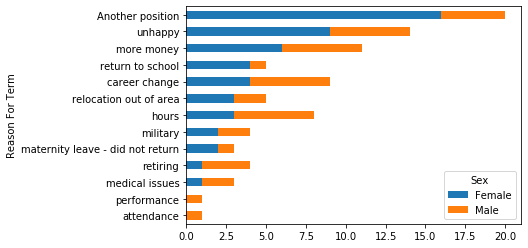

In [38]:
pd.crosstab(index=hrd9_v2['Reason For Term'][hrd9_v2['Reason For Term']!='N/A - still employed'], \
            columns=hrd9_v2['Sex']).sort_values(by='Female').plot.barh(stacked=True)
plt.show()

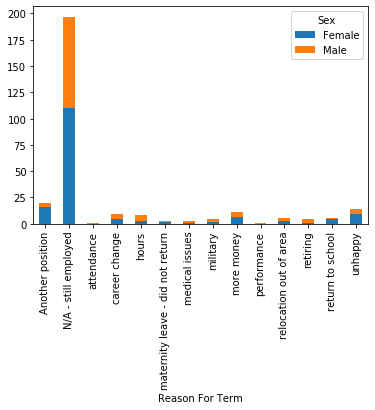

In [39]:
pd.crosstab(index=hrd9_v2['Reason For Term'], columns=hrd9_v2['Sex']).plot.bar(stacked=True)

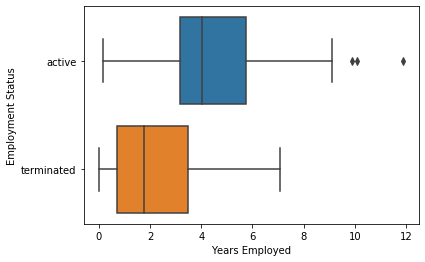

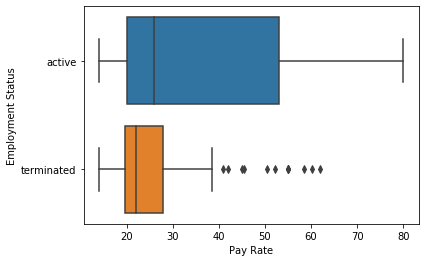

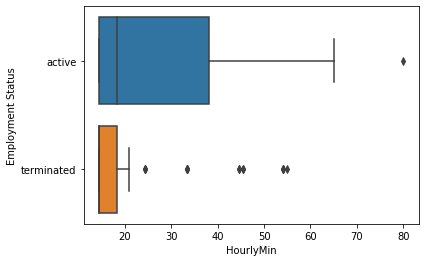

In [40]:
sns.boxplot(x='Years Employed', y='Employment Status', data=hrd9_v2)
plt.show()
sns.boxplot(x='Pay Rate', y='Employment Status', data=hrd9_v2)
plt.show()
sns.boxplot(x='HourlyMin', y='Employment Status', data=hrd9_v2)
plt.show()

In [41]:
hrd9_v2['HourlyMin'].describe()

count    285.000000
mean      25.056491
std       15.189607
min       14.420000
25%       14.420000
50%       18.270000
75%       33.500000
max       80.000000
Name: HourlyMin, dtype: float64

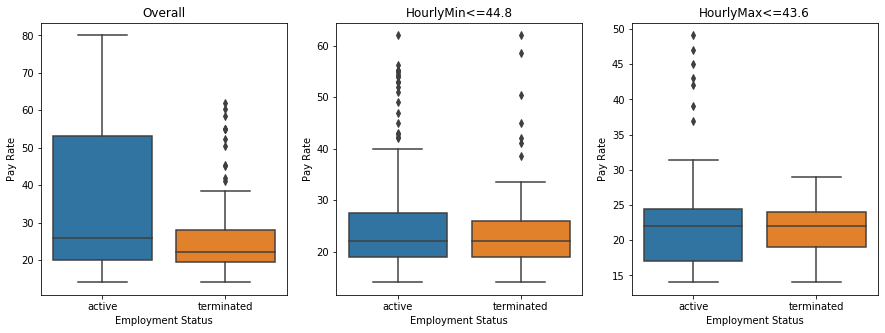

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(y='Pay Rate', x='Employment Status', data=hrd9_v2, ax=axes[0])
sns.boxplot(y='Pay Rate', x='Employment Status', data=hrd9_v2[hrd9_v2['HourlyMin']<=44.8], ax=axes[1])
sns.boxplot(y='Pay Rate', x='Employment Status', data=hrd9_v2[hrd9_v2['HourlyMax']<=43.6], ax=axes[2])
axes[0].title.set_text('Overall')
axes[1].title.set_text('HourlyMin<=44.8')
axes[2].title.set_text('HourlyMax<=43.6')
plt.show()

In [43]:
feat_importances = lr.best_estimator_.coef_[0]
srt = sorted(zip(xtrain.columns, feat_importances), key=lambda k: (-k[1]))
srt = list(map(list, zip(*srt)))

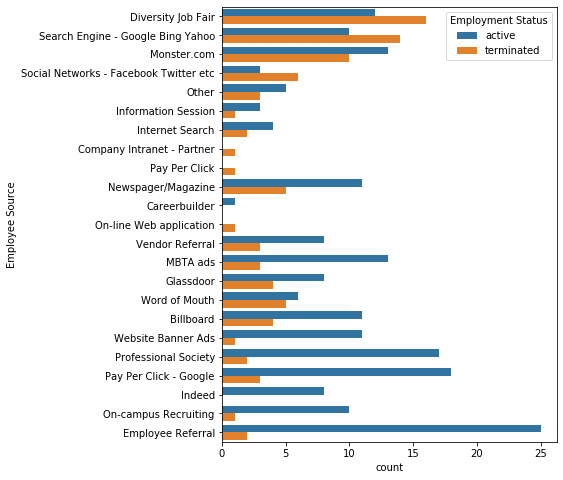

In [44]:
plt.figure(figsize=(6,8))
sns.countplot(y=hrd9_v2['Employee Source'], hue=hrd9_v2['Employment Status'], order=[x[16:] for x in srt[0] if 'Employee Source' in x])
plt.show()

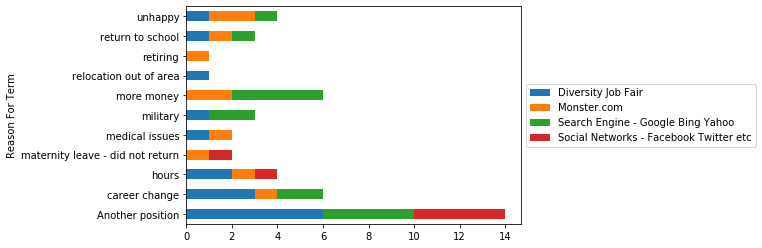

In [127]:
hrd9_v3 = hrd9_v2[hrd9_v2['Employee Source'].isin(['Diversity Job Fair', 'Search Engine - Google Bing Yahoo', 'Monster.com', 'Social Networks - Facebook Twitter etc'])]
pd.crosstab(index=hrd9_v3['Reason For Term'][hrd9_v3['Reason For Term']!='N/A - still employed'], \
            columns=hrd9_v3['Employee Source']).plot.barh(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [104]:
# build table of most cost-effective employee sources
# higher value = higher effectiveness
# formula = percentage of employees from that source retained / cost
employees_retained = (hrd9_v2[hrd9_v2['Employment Status']=='active'].groupby(['Employee Source'])['Employment Status'].agg('count')/hrd9_v2.groupby(['Employee Source'])['Employment Status'].agg('count')).fillna(0)
((employees_retained/recruitcosts_df.set_index('Employment Source')['Total']).replace([np.inf, -np.inf], np.nan).dropna()).sort_values()

Pay Per Click                             0.000000
Diversity Job Fair                        0.000043
Social Networks - Facebook Twitter etc    0.000060
MBTA ads                                  0.000074
Search Engine - Google Bing Yahoo         0.000080
Newspager/Magazine                        0.000083
Monster.com                               0.000098
Billboard                                 0.000118
On-campus Recruiting                      0.000121
Website Banner Ads                        0.000128
Careerbuilder                             0.000128
Other                                     0.000156
Pay Per Click - Google                    0.000244
Professional Society                      0.000746
dtype: float64

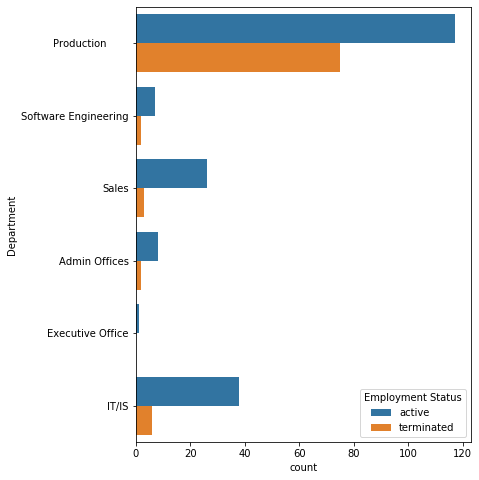

In [46]:
plt.figure(figsize=(6,8))
sns.countplot(y=hrd9_v2['Department'], hue=hrd9_v2['Employment Status'], order=[x[11:] for x in srt[0] if 'Department' in x])
plt.show()

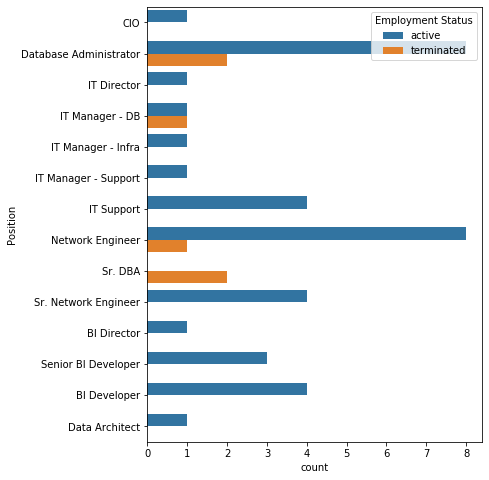

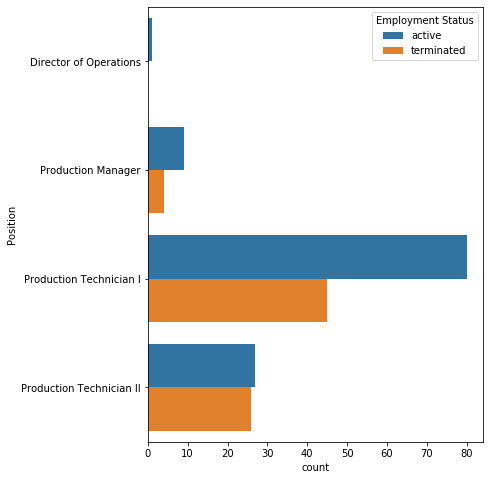

In [47]:
# Exploring positions under IT/IS and Production

plt.figure(figsize=(6,8))
sns.countplot(y=hrd9_v2[hrd9_v2['Department']=='IT/IS']['Position'], hue=hrd9_v2[hrd9_v2['Department']=='IT/IS']['Employment Status'])
plt.show()

plt.figure(figsize=(6,8))
sns.countplot(y=hrd9_v2[hrd9_v2['Department']=='Production       ']['Position'], hue=hrd9_v2[hrd9_v2['Department']=='Production       ']['Employment Status'])
plt.show()

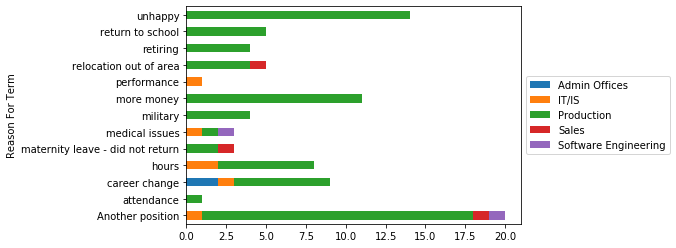

In [48]:
pd.crosstab(index=hrd9_v2['Reason For Term'][hrd9_v2['Reason For Term']!='N/A - still employed'], \
            columns=hrd9_v2['Department']).plot.barh(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [49]:
hrd9_v2.groupby(['Department'])['Pay Rate'].agg(['min', 'mean', 'median', 'max']).sort_values(by='mean')

,min,mean,median,max
Department,,,,
Production,14.00,23.153385,22.00,60.00
Admin Offices,16.56,31.896000,28.75,55.00
IT/IS,21.00,45.104091,45.00,65.00
Software Engineering,27.00,48.683333,49.25,57.12
Sales,54.00,55.560345,55.00,60.25
Executive Office,80.00,80.000000,80.00,80.00


In [111]:
pd.crosstab(index=hrd9_v2['payRate>=mid'], columns=hrd9_v2['Employment Status'])

Employment Status,active,terminated
payRate>=mid,,
no,62,36
yes,135,52
